In [ ]:
import numpy as np 
import pandas as pd 
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

In [ ]:

def load_images_for_cnn(training_directory, batch_size=32, target_size=(224, 224), keyword="Grape"):
    data_generator = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = data_generator.flow_from_directory(
        training_directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        classes=[dir for dir in os.listdir(training_directory) if keyword in dir]
    )

    validation_generator = data_generator.flow_from_directory(
        training_directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        classes=[dir for dir in os.listdir(training_directory) if keyword in dir]
    )

    return train_generator, validation_generator


In [ ]:
train_generator, validation_generator = load_images_for_cnn('/kaggle/input/plantvillage-dataset/color', batch_size=32, target_size=(224, 224), keyword="Grape")

In [ ]:
# Base modelin oluşturulması 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)


predictions = Dense(4, activation='softmax')(x) # Çıkış katmanında softmax daha iyi sonuçlar verdi
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:

history = model.fit(
    train_generator,  
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,  
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=1
)

In [ ]:
#Görselleştirme
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

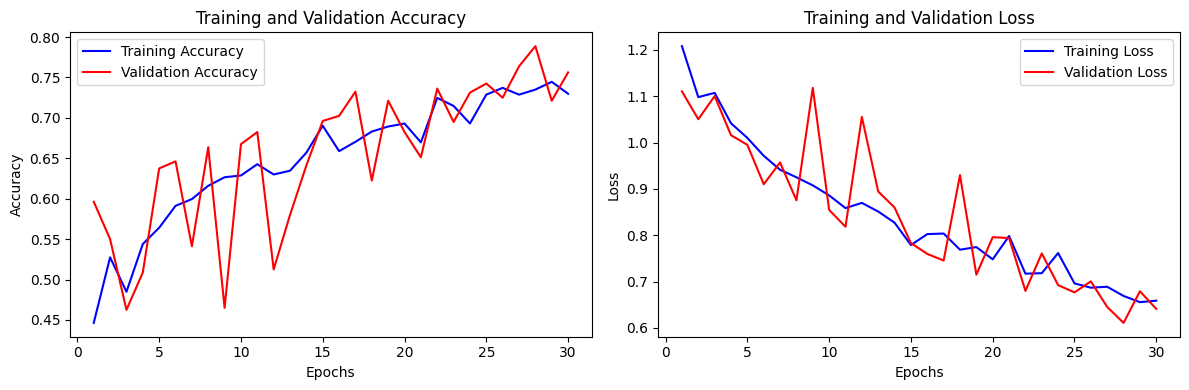